Hunter Bennett | June 16 2021

In [1]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
%matplotlib inline
### imports ###
import sys
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib_venn import venn3
import seaborn as sns

# import custom functions
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from homer_preprocessing import import_homer_diffgene, read_homer_gene_exp, read_annotated_peaks
from plotting_scripts import plot_exp_rpkm, gene_list_bar_plot

In [2]:
f1Dir = '/home/ttroutman/strainsKupffer/rnaKupfferF1/'
nsgDir = '/home/ttroutman/strainsKupffer/rnaKupfferNSG_20210201/'
workingDirectory = '/home/h1bennet/strains_manuscript/results/03_Strains_Manuscript_Compare_CB6F1_NSG//'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)

In [3]:
#### PLOTTING PARAMETERS FOR MANUSCRIPT ####
# # get matplotlib to save readable fonts
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.size'] = 6
matplotlib.rcParams['savefig.dpi'] = 500


# line widths
matplotlib.rcParams['axes.linewidth'] = 1
matplotlib.rcParams['xtick.major.width'] = 1
matplotlib.rcParams['ytick.major.width'] = 1

# adjust defualt color for plots to black
# normal default is a dark gray
COLOR = 'black'
matplotlib.rcParams['text.color'] = COLOR
matplotlib.rcParams['axes.labelcolor'] = COLOR
matplotlib.rcParams['xtick.color'] = COLOR
matplotlib.rcParams['ytick.color'] = COLOR
matplotlib.rcParams['axes.edgecolor'] = COLOR

#### PLOT PARAMETERS FOR THIS PLOT ####

# Compare cis / trans / mixed lists...
How many trans regulated genes are shared between sets...

In [4]:
os.listdir('/home/h1bennet/strains_rna/results/K03_CB6F1_Kupffer_RNA/gene_lists/')

['cb6f1_kupffer_trans_c57_filt_pval',
 '._cb6f1_kupffer_trans_c57.txt',
 'cb6f1_kupffer_trans_balb_filt_pval.txt',
 '._.DS_Store',
 '._cb6f1_kupffer_trans_balb_filt',
 'cb6f1_kupffer_mixed_c57_filt.txt',
 'cb6f1_kupffer_cis_balb_filt_pval.txt',
 'cb6f1_kupffer_trans_balb_filt.txt',
 '._cb6f1_kupffer_trans_c57',
 'cb6f1_kupffer_trans_c57_filt',
 'cb6f1_kupffer_cis_c57_filt_pval.txt',
 '._cb6f1_kupffer_cis_balb_filt_pval',
 '._cb6f1_kupffer_trans_c57_filt_pval.txt',
 '._cb6f1_kupffer_trans_balb_filt_pval',
 '._cb6f1_kupffer_trans_c57_filt.txt',
 'cb6f1_kupffer_mixed_balb_filt.txt',
 'cb6f1_kupffer_trans_c57_filt_pval.txt',
 '._cb6f1_kupffer_mixed_c57',
 'cb6f1_kupffer_mixed_balb',
 '._cb6f1_kupffer_trans_balb',
 'cb6f1_kupffer_mixed_balb_filt_pval',
 'cb6f1_kupffer_mixed_c57',
 '._cb6f1_kupffer_trans_c57_filt',
 '._cb6f1_kupffer_mixed_c57_filt_pval',
 'cb6f1_kupffer_mixed_balb_filt',
 '._cb6f1_kupffer_cis_balb_filt_pval.txt',
 '._cb6f1_kupffer_mixed_balb_filt_pval',
 'cb6f1_kupffer_cis_c

In [5]:
f1_dict = {}
for genelist in glob.glob('/home/h1bennet/strains_rna/results/K03_CB6F1_Kupffer_RNA/gene_lists/*filt_pval.txt'):
    with open(genelist, 'r') as f:
        listid = genelist.split('/')[-1].replace('.txt','')
        f1_dict[listid] = [i.strip() for i in f.readlines()[1:]]

In [6]:
nsg_dict = {}
for genelist in glob.glob('/home/h1bennet/strains_rna/results/K03_NSG_Kupffer_RNA/gene_lists/*filt_pval.txt'):
    with open(genelist, 'r') as f:
        listid = genelist.split('/')[-1].replace('.txt','')
        nsg_dict[listid] = [i.strip() for i in f.readlines()[1:]]

Compare overlap of all sets...

In [7]:
for key in f1_dict.keys():
    print(key)
    print(len(f1_dict[key]), 'genes in F1 set')
    print(len(nsg_dict[key]), 'genes in NSG set')
    shared = set(nsg_dict[key]).intersection(f1_dict[key])
    total = set(nsg_dict[key]).union(f1_dict[key])
    print('%i / %i genes shared' % (len(shared), len(total)))

cb6f1_kupffer_trans_balb_filt_pval
63 genes in F1 set
84 genes in NSG set
35 / 112 genes shared
cb6f1_kupffer_cis_balb_filt_pval
39 genes in F1 set
77 genes in NSG set
27 / 89 genes shared
cb6f1_kupffer_cis_c57_filt_pval
44 genes in F1 set
73 genes in NSG set
36 / 81 genes shared
cb6f1_kupffer_trans_c57_filt_pval
61 genes in F1 set
88 genes in NSG set
44 / 105 genes shared
cb6f1_kupffer_mixed_c57_filt_pval
33 genes in F1 set
17 genes in NSG set
2 / 48 genes shared
cb6f1_kupffer_mixed_balb_filt_pval
52 genes in F1 set
18 genes in NSG set
3 / 67 genes shared


In [8]:
df_f1 = pd.read_csv('/home/ttroutman/strainsKupffer/rnaKupfferF1//rnaDiff/balbcj_variants.vs.c57bl6j_variants.scatter.txt',
                    sep='\t', index_col=0)


In [9]:
df_nsg = pd.read_csv('/home/ttroutman/strainsKupffer/rnaKupfferNSG_20210201//rnaDiff/balbcj_NSG.vs.c57bl6j_NSG.scatter.txt',
                 sep='\t', index_col=0)

In [10]:
df_control = pd.read_csv('/home/ttroutman/strainsKupffer/rnaKupfferNSG_20210201//rnaDiff/balbcj_control.vs.c57bl6j_control.scatter.txt',
                         sep='\t', index_col=0)

In [11]:
df = df_control.merge(df_f1.merge(df_nsg, left_index=True, right_index=True, how='inner', suffixes=('_f1','_nsg')),
                      left_index=True,
                      right_index=True,
                      how='inner',
                      suffixes=('_control', ''))

In [12]:
2**-df.loc['Oas3', df.columns.str.contains('log2FoldChange')]

log2FoldChange         2.12664
log2FoldChange_f1     0.916636
log2FoldChange_nsg     2.14485
Name: Oas3, dtype: object

# We will use a custom ordering to separate into F0, F1, NSG specific

First write out sets to a new list

In [13]:
if not os.path.isdir('./gene_list_subsets/'):
    os.mkdir('./gene_list_subsets')

In [14]:
for key in nsg_dict.keys():
    
    shared_set = df.reindex(set(nsg_dict[key]).intersection(f1_dict[key])).dropna().index.tolist()
    f1_only = df.reindex(set(f1_dict[key]).difference(nsg_dict[key])).dropna().index.tolist()
    nsg_only = df.reindex(set(nsg_dict[key]).difference(f1_dict[key])).dropna().index.tolist()
    
    sets = [shared_set, f1_only, nsg_only]
    set_labels = ['shared_set', 'f1_only', 'nsg_only']
    
    for listname, genelist in zip(set_labels, sets):
        print(key+'_'+listname, ":", len(genelist))
        with open('./gene_list_subsets/'+key+'_'+listname+'_.txt', 'w') as f:
            f.write('Gene\n')
            for i in genelist:
                f.write(i+'\n')
            f.close()

cb6f1_kupffer_trans_balb_filt_pval_shared_set : 35
cb6f1_kupffer_trans_balb_filt_pval_f1_only : 23
cb6f1_kupffer_trans_balb_filt_pval_nsg_only : 5
cb6f1_kupffer_cis_balb_filt_pval_shared_set : 27
cb6f1_kupffer_cis_balb_filt_pval_f1_only : 5
cb6f1_kupffer_cis_balb_filt_pval_nsg_only : 23
cb6f1_kupffer_cis_c57_filt_pval_shared_set : 36
cb6f1_kupffer_cis_c57_filt_pval_f1_only : 3
cb6f1_kupffer_cis_c57_filt_pval_nsg_only : 14
cb6f1_kupffer_trans_c57_filt_pval_shared_set : 44
cb6f1_kupffer_trans_c57_filt_pval_f1_only : 15
cb6f1_kupffer_trans_c57_filt_pval_nsg_only : 3
cb6f1_kupffer_mixed_c57_filt_pval_shared_set : 2
cb6f1_kupffer_mixed_c57_filt_pval_f1_only : 30
cb6f1_kupffer_mixed_c57_filt_pval_nsg_only : 6
cb6f1_kupffer_mixed_balb_filt_pval_shared_set : 3
cb6f1_kupffer_mixed_balb_filt_pval_f1_only : 48
cb6f1_kupffer_mixed_balb_filt_pval_nsg_only : 9


# Check promoter motifs just in case

In [15]:
if not os.path.isdir('./promoter_motif_subsets/'):
    os.mkdir('./promoter_motif_subsets/')

In [16]:
%%bash

for i in ./gene_list_subsets/*.txt;
do out=${i/gene_list_subsets/promoter_motif_subsets};
out=${out/.txt/_motifs};
findMotifs.pl $i mouse $out -p 8; done

Process is interrupted.


## Trans

In [20]:
df.columns

Index(['baseMean', 'log2FoldChange', 'lfcSE', 'stat', 'pvalue', 'padj',
       'contrast', 'baseMean_f1', 'log2FoldChange_f1', 'lfcSE_f1', 'stat_f1',
       'pvalue_f1', 'padj_f1', 'contrast_f1', 'baseMean_nsg',
       'log2FoldChange_nsg', 'lfcSE_nsg', 'stat_nsg', 'pvalue_nsg', 'padj_nsg',
       'contrast_nsg'],
      dtype='object')

In [21]:
log2fc_cols = ['log2FoldChange',
             'log2FoldChange_nsg',
             'log2FoldChange_f1']

44
15
3


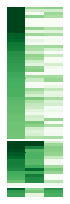

In [22]:
key = 'cb6f1_kupffer_trans_c57_filt_pval'
shared_set = df.reindex(set(nsg_dict[key]).intersection(f1_dict[key])).dropna().index.tolist()
f1_only = df.reindex(set(f1_dict[key]).difference(nsg_dict[key])).dropna().index.tolist()
nsg_only = df.reindex(set(nsg_dict[key]).difference(f1_dict[key])).dropna().index.tolist()

sets = [shared_set, f1_only, nsg_only]
set_lengths = [len(i) for i in sets]

f, axs = plt.subplots(3, 1, figsize=(1,3.5), gridspec_kw={'height_ratios': set_lengths})
plt.subplots_adjust(hspace=0.025)
for geneset, ax in zip(sets, axs):
    print(len(geneset))
    sns.heatmap(df.loc[geneset, log2fc_cols].sort_values('log2FoldChange', ascending=False),
                cmap='Greens',
                # linewidth=1,
                # linecolor='k',
                # z_score=2,
                vmin=0,
                vmax=2,
                # annot=True,
                fmt='.1f',
                xticklabels=0,
                yticklabels=0,
                cbar=False,
                cbar_kws={'orientation':'vertical',
                          'pad':0.05,
                          'label':'-log2fc'},
                ax=ax)

plt.savefig('./figures/'+key+'_heatmap_custom_order.pdf',
            bbox_inches='tight')

35
23
5


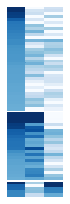

In [23]:
key = 'cb6f1_kupffer_trans_balb_filt_pval'
shared_set = df.reindex(set(nsg_dict[key]).intersection(f1_dict[key])).dropna().index.tolist()
f1_only = df.reindex(set(f1_dict[key]).difference(nsg_dict[key])).dropna().index.tolist()
nsg_only = df.reindex(set(nsg_dict[key]).difference(f1_dict[key])).dropna().index.tolist()

sets = [shared_set, f1_only, nsg_only]
set_lengths = [len(i) for i in sets]

f, axs = plt.subplots(3, 1, figsize=(1,3.5), gridspec_kw={'height_ratios': set_lengths})
plt.subplots_adjust(hspace=0.025)
for geneset, ax in zip(sets, axs):
    print(len(geneset))
    sns.heatmap(-df.loc[geneset, log2fc_cols].sort_values('log2FoldChange', ascending=True),
                cmap='Blues',
                # linewidth=1,
                # linecolor='k',
                # z_score=2,
                vmin=0,
                vmax=2,
                # annot=True,
                fmt='.1f',
                xticklabels=0,
                yticklabels=0,
                cbar=False,
                cbar_kws={'orientation':'horizontal',
                          'pad':0.05,
                          'label':'-log2fc'},
                ax=ax)

plt.savefig('./figures/'+key+'_heatmap_custom_order.pdf',
            bbox_inches='tight')

# Mixed

2
30
6


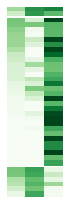

In [62]:
key = 'cb6f1_kupffer_mixed_c57_filt_pval'
shared_set = df.reindex(set(nsg_dict[key]).intersection(f1_dict[key])).dropna().index.tolist()
f1_only = df.reindex(set(f1_dict[key]).difference(nsg_dict[key])).dropna().index.tolist()
nsg_only = df.reindex(set(nsg_dict[key]).difference(f1_dict[key])).dropna().index.tolist()

sets = [shared_set, f1_only, nsg_only]
set_lengths = [len(i) for i in sets]

f, axs = plt.subplots(3, 1, figsize=(1,3.5), gridspec_kw={'height_ratios': set_lengths})
plt.subplots_adjust(hspace=0.025)
for geneset, ax in zip(sets, axs):
    print(len(geneset))
    sns.heatmap(df.loc[geneset, log2fc_cols].sort_values('log2FoldChange', ascending=False),
                cmap='Greens',
                # linewidth=1,
                # linecolor='k',
                # z_score=2,
                vmin=0,
                vmax=2,
                # annot=True,
                fmt='.1f',
                xticklabels=0,
                yticklabels=0,
                cbar=False,
                cbar_kws={'orientation':'vertical',
                          'pad':0.05,
                          'label':'-log2fc'},
                ax=ax)
    

plt.savefig('./figures/'+key+'_heatmap_custom_order.pdf',
            bbox_inches='tight')

3
48
9


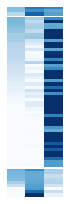

In [63]:
key = 'cb6f1_kupffer_mixed_balb_filt_pval'
shared_set = df.reindex(set(nsg_dict[key]).intersection(f1_dict[key])).dropna().index.tolist()
f1_only = df.reindex(set(f1_dict[key]).difference(nsg_dict[key])).dropna().index.tolist()
nsg_only = df.reindex(set(nsg_dict[key]).difference(f1_dict[key])).dropna().index.tolist()

sets = [shared_set, f1_only, nsg_only]
set_lengths = [len(i) for i in sets]

f, axs = plt.subplots(3, 1, figsize=(1,3.5), gridspec_kw={'height_ratios': set_lengths})
plt.subplots_adjust(hspace=0.025)
for geneset, ax in zip(sets, axs):
    print(len(geneset))
    sns.heatmap(-df.loc[geneset, log2fc_cols].sort_values('log2FoldChange', ascending=True),
                cmap='Blues',
                # linewidth=1,
                # linecolor='k',
                # z_score=2,
                vmin=0,
                vmax=2,
                # annot=True,
                fmt='.1f',
                xticklabels=0,
                yticklabels=0,
                cbar=False,
                cbar_kws={'orientation':'horizontal',
                          'pad':0.05,
                          'label':'-log2fc'},
                ax=ax)
    

plt.savefig('./figures/'+key+'_heatmap_custom_order.pdf',
            bbox_inches='tight')

36
3
14


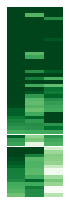

In [64]:
key = 'cb6f1_kupffer_cis_c57_filt_pval'
shared_set = df.reindex(set(nsg_dict[key]).intersection(f1_dict[key])).dropna().index.tolist()
f1_only = df.reindex(set(f1_dict[key]).difference(nsg_dict[key])).dropna().index.tolist()
nsg_only = df.reindex(set(nsg_dict[key]).difference(f1_dict[key])).dropna().index.tolist()

sets = [shared_set, f1_only, nsg_only]
set_lengths = [len(i) for i in sets]

f, axs = plt.subplots(3, 1, figsize=(1,3.5), gridspec_kw={'height_ratios': set_lengths})
plt.subplots_adjust(hspace=0.025)
for geneset, ax in zip(sets, axs):
    print(len(geneset))
    sns.heatmap(df.loc[geneset, log2fc_cols].sort_values('log2FoldChange', ascending=False),
                cmap='Greens',
                # linewidth=1,
                # linecolor='k',
                # z_score=2,
                vmin=0,
                vmax=2,
                # annot=True,
                fmt='.1f',
                xticklabels=0,
                yticklabels=0,
                cbar=False,
                cbar_kws={'orientation':'vertical',
                          'pad':0.05,
                          'label':'-log2fc'},
                ax=ax)


plt.savefig('./figures/'+key+'_heatmap_custom_order.pdf',
            bbox_inches='tight')

27
5
23


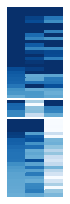

In [65]:
key = 'cb6f1_kupffer_cis_balb_filt_pval'
shared_set = df.reindex(set(nsg_dict[key]).intersection(f1_dict[key])).dropna().index.tolist()
f1_only = df.reindex(set(f1_dict[key]).difference(nsg_dict[key])).dropna().index.tolist()
nsg_only = df.reindex(set(nsg_dict[key]).difference(f1_dict[key])).dropna().index.tolist()

sets = [shared_set, f1_only, nsg_only]
set_lengths = [len(i) for i in sets]

f, axs = plt.subplots(3, 1, figsize=(1,3.5), gridspec_kw={'height_ratios': set_lengths})
plt.subplots_adjust(hspace=0.025)
for geneset, ax in zip(sets, axs):
    print(len(geneset))
    sns.heatmap(-df.loc[geneset, log2fc_cols].sort_values('log2FoldChange', ascending=True),
                cmap='Blues',
                # linewidth=1,
                # linecolor='k',
                # z_score=2,
                vmin=0,
                vmax=2,
                # annot=True,
                fmt='.1f',
                xticklabels=0,
                yticklabels=0,
                cbar=False,
                cbar_kws={'orientation':'horizontal',
                          'pad':0.05,
                          'label':'-log2fc'},
                ax=ax)
    

plt.savefig('./figures/'+key+'_heatmap_custom_order.pdf',
            bbox_inches='tight')

# Make colorbars

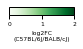

In [66]:
fig, ax = plt.subplots(figsize=(2,1))

cmap = matplotlib.cm.Greens
norm = matplotlib.colors.Normalize(vmin=0, vmax=2)
plt.gca().set_visible(False)
cb = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm,  cmap=cmap),
                  use_gridspec=True,
                  orientation='horizontal',
                  label='log2FC\n(C57BL/6J/BALB/cJ)',
                  aspect=8)
plt.savefig('./figures/c57bl6j_colorbar.pdf',
            bbox_inches='tight')

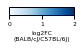

In [67]:
fig, ax = plt.subplots(figsize=(2,1))

cmap = matplotlib.cm.Blues
norm = matplotlib.colors.Normalize(vmin=0, vmax=2)
plt.gca().set_visible(False)
cb = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm,  cmap=cmap),
                  use_gridspec=True,
                  orientation='horizontal',
                  label='log2FC\n(BALB/cJ/C57BL/6J)',
                  aspect=8)
plt.savefig('./figures/balbcj_colorbar.pdf',
            bbox_inches='tight')